# 오토인코더 (AutoEncoder)
 

# 텐서플로우 및 CIFAR-10 불러오기

---
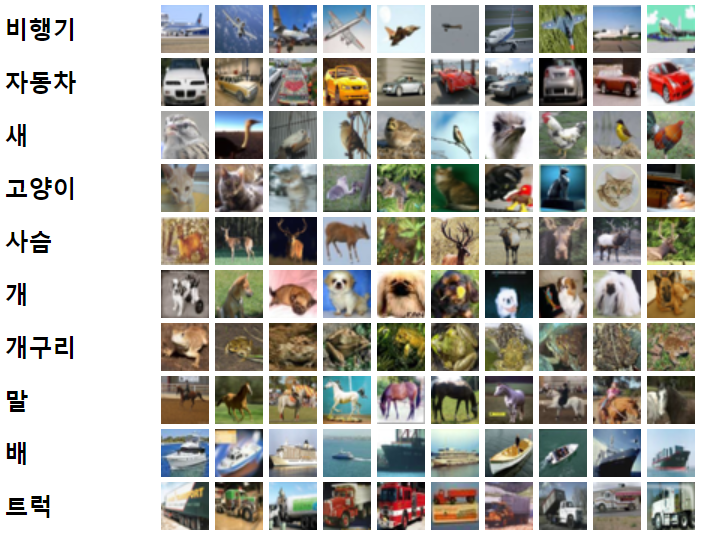


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets.cifar10 import load_data

cifar10 = tf.keras.datasets.cifar10
(train_X, train_Y), (test_X,test_Y) = cifar10.load_data()

# 픽셀 정규화 과정 및 이미지 확인  

In [ ]:
print(train_X.shape, train_Y.shape)
train_X = train_X / 255.0
test_X = test_X / 255.0

(50000, 32, 32, 3) (50000, 1)


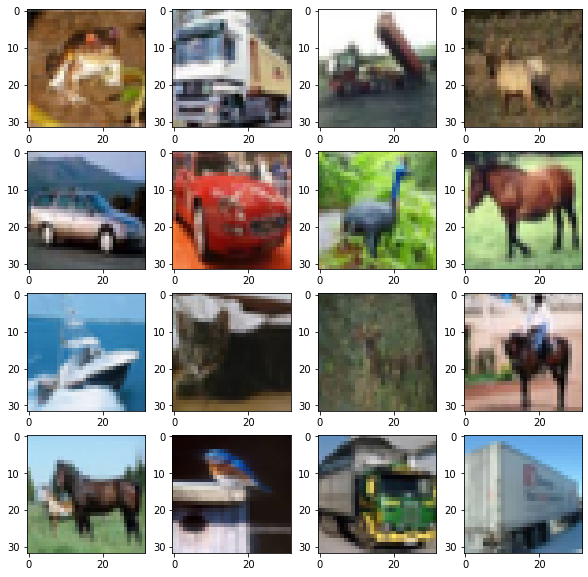

[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]
 [4]
 [7]
 [7]
 [2]
 [9]
 [9]]


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(train_X[i].reshape(32,32,3))

plt.show()
print(train_Y[:16])

# 컨볼루션 오토인코더 모델 정의
 * 입력크기와 출력크기가 최대한 같은 값을 갖도록 
 * 중간 완전연결계층을 중심으로 인코더와 디코더의 크기(shape)를 최대한 일치
 * Conv2DTranspose(디컨볼루션 레이어) : 
   * Conv2D레이어가 하는 일의 반대되는 계산, 즉 입력이 되는 하나의 값을 컨볼루션에 통과시켜 출력의 여러값을 계산해주는 레이어 

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation='relu',input_shape=(32,32,3)), 
                             tf.keras.layers.MaxPool2D(strides = (2,2),pool_size=(2,2)), 
                             tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation='relu'), 
                             tf.keras.layers.MaxPool2D(strides = (2,2),pool_size=(2,2)),
                             tf.keras.layers.Flatten(), 
                             tf.keras.layers.Dense(36, activation='relu'), 
                             tf.keras.layers.Dense(8*8*36, activation='relu'), 
                             tf.keras.layers.Reshape(target_shape=(8,8,36)), 
                             tf.keras.layers.Conv2DTranspose(filters = 32,kernel_size=3, strides=2,padding='same',activation='relu'),
                             tf.keras.layers.Conv2DTranspose(filters = 3, kernel_size=3, strides=2,padding='same', activation='sigmoid') #마지막 활성화 함수는 0~1사이의 값을 갖는 컬러값을 출력하도록 셋팅 
                              ])

# 비선형 활성화 함수 elu(Exponential linear units)

 * 음수인 경우 0이 아닌 -1에 부드럽게 수렴
 * 원본에 비해 출력값이 다소 각지는 현상이 발생할 때 사용되는 활성화 함수 
   * 각지는 현상은 신경망일부분의 값이 아예 사라지는 현상 
   * 뉴런의 계산값 중 음수가 되는 결과가 많은 경우, 그 뉴런의 출력은 무조건 0 
   * 출력이 0이면 다음 레이어의 가중치에 곱해지는 값의 결과도 계속 0. 즉 픽셀값이 0으로 고정 

* elu는 0 이하에서 부드럽게 감소하며 -1에 수렴.
 * 약간 값이 남아있는 것으로도 픽셀이 사라지는 현상 해소      

 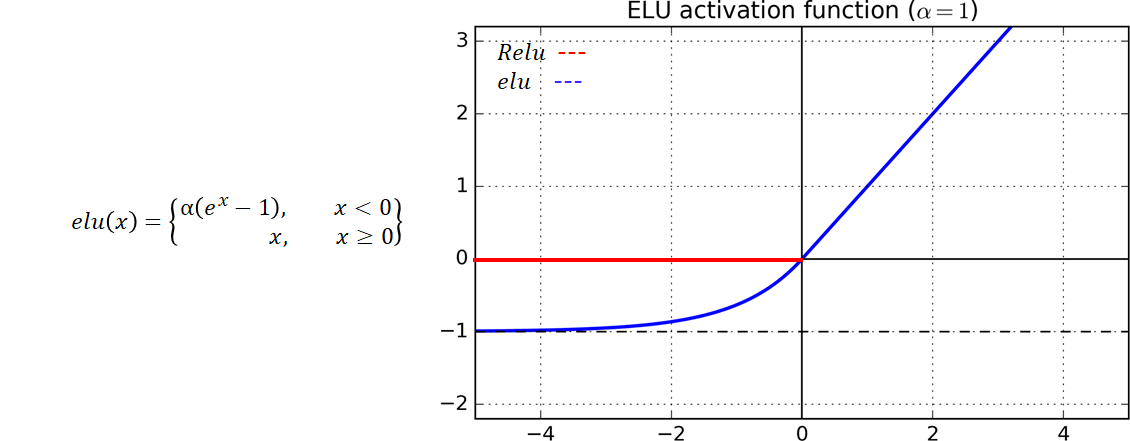

# 오토인코더 신경망 구조 설계

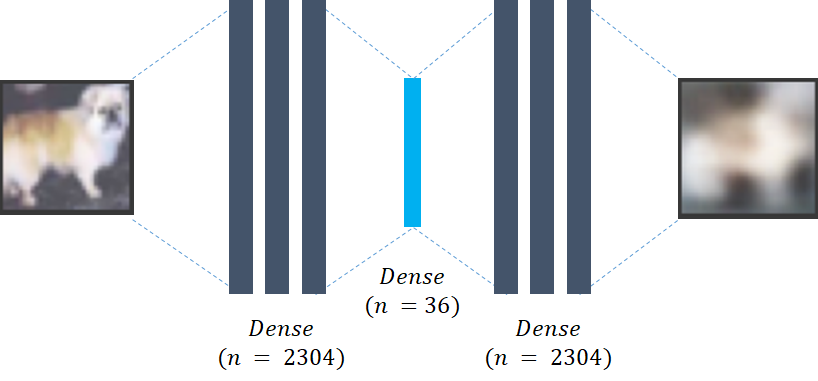

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation='elu',input_shape=(32,32,3)), 
                             tf.keras.layers.MaxPool2D(strides = (2,2),pool_size=(2,2)), 
                             tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation='elu'), 
                             tf.keras.layers.MaxPool2D(strides = (2,2),pool_size=(2,2)),
                             tf.keras.layers.Flatten(), 
                             tf.keras.layers.Dense(36, activation='elu'), 
                             tf.keras.layers.Dense(8*8*36, activation='elu'), 
                             tf.keras.layers.Reshape(target_shape=(8,8,36)), 
                             tf.keras.layers.Conv2DTranspose(filters = 32,kernel_size=3, strides=2,padding='same',activation='elu'),
                             tf.keras.layers.Conv2DTranspose(filters = 3, kernel_size=3, strides=2,padding='same', activation='sigmoid') #마지막 활성화 함수는 0~1사이의 값을 갖는 컬러값을 출력하도록 셋팅 
                              ])

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(), loss = 'mse')
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 2304)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 36)                82980     
_________________________________________________________________
dense_49 (Dense)             (None, 2304)            

# 모델 학습 
 - 모델의 입력과 출력에 해당하는 부분에 모두 train_X를 넣어 입력에 대해 동일한 출력을 얻을 수 있도록 설정 

In [ ]:
model.fit(train_X,
          train_X,
          epochs=100, 
          batch_size=256,
          callbacks = [tf.keras.callbacks.EarlyStopping(patience = 10, monitor = 'loss')])

Epoch 1/100
196/196 [==============================] - 2s 8ms/step - loss: 0.0310
Epoch 2/100
196/196 [==============================] - 2s 8ms/step - loss: 0.0168
Epoch 3/100
196/196 [==============================] - 2s 8ms/step - loss: 0.0153
Epoch 4/100
196/196 [==============================] - 2s 8ms/step - loss: 0.0149
Epoch 5/100
196/196 [==============================] - 2s 8ms/step - loss: 0.0146
Epoch 6/100
196/196 [==============================] - 2s 8ms/step - loss: 0.0144
Epoch 7/100
196/196 [==============================] - 2s 8ms/step - loss: 0.0141
Epoch 8/100
196/196 [==============================] - 2s 8ms/step - loss: 0.0139
Epoch 9/100
196/196 [==============================] - 2s 8ms/step - loss: 0.0137
Epoch 10/100
196/196 [==============================] - 2s 8ms/step - loss: 0.0136
Epoch 11/100
196/196 [==============================] - 2s 8ms/step - loss: 0.0135
Epoch 12/100
196/196 [==============================] - 2s 8ms/step - loss: 0.0134
Epoch 13/100


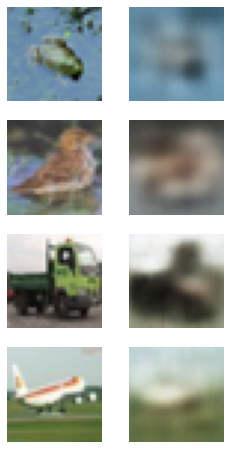

313/313 [==============================] - 1s 2ms/step - loss: 0.0116


0.011624093167483807

In [ ]:
import random
import numpy as np

plt.figure(figsize=(4,8))
for c in range(4):
  plt.subplot(4,2,c*2+1)
  rand_index = random.randint(0,test_X.shape[0])
  plt.imshow(test_X[rand_index].reshape(32,32,3))
  plt.axis('off')

  plt.subplot(4,2,c*2+2)
  img = model.predict(np.expand_dims(test_X[rand_index], axis = 0))
  plt.imshow(img.reshape(32,32,3))
  plt.axis('off')

plt.show()

model.evaluate(test_X,test_X)

# 오토인코더의 또 다른 기능 
* 인코더가 잠재변수를 만드는 과정에서 주요한 정보 외에 주변 픽셀들은 
 데이터를 표현하는 주요한 정보에 포함되지 않기에 제거 즉, 노이즈를 제가하는 효과도 얻을 수 있습니다. 